In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

In [58]:
import scipy.stats as ss

In [59]:
from scipy.stats import gennorm

In [10]:
import yfinance as yf

prices = yf.download('MSFT','2017-07-01','2020-06-30')
prices.index = prices.index.to_period(freq='d')

prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-30,68.779999,69.379997,68.739998,68.930000,64.966385,24161100
2017-07-03,69.330002,69.599998,68.019997,68.169998,64.250069,16165500
2017-07-05,68.260002,69.440002,68.220001,69.080002,65.107765,21176300
2017-07-06,68.269997,68.779999,68.120003,68.570000,64.627075,21117600
2017-07-07,68.699997,69.839996,68.699997,69.459999,65.465904,16878300


In [32]:
ret = prices['Adj Close'].pct_change().dropna()
alpha = 0.05

In [33]:
def calc_VaR(r, VaR_fun, L_history=252, level=alpha):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [74]:
from arch import arch_model 
from arch.univariate import GARCH, EGARCH, ConstantMean, SkewStudent

mdl = arch_model(ret*100) 

res = mdl.fit(disp= 'off')
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1355.55
Distribution:                  Normal   AIC:                           2719.10
Method:            Maximum Likelihood   BIC:                           2737.59
                                        No. Observations:                  753
Date:                Fri, Sep 24 2021   Df Residuals:                      752
Time:                        22:32:15   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2069  4.523e-02      4.574  4.786e-06 [  0.118,  0.29

In [75]:
mdl = arch_model(100 * ret, vol='EGARCH', p=2, o=1, q=2, dist = 'skewstudent') 

res = mdl.fit(disp= 'off')
res

                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                         Adj Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -1320.89
Distribution:      Standardized Skew Student's t   AIC:                           2659.79
Method:                       Maximum Likelihood   BIC:                           2701.40
                                                   No. Observations:                  753
Date:                           Fri, Sep 24 2021   Df Residuals:                      752
Time:                                   22:32:21   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [92]:
def calculate_VaR_pot(ret, alpha=0.05):
    
    u = ret.quantile(0.2)
    ret_tail = ret[ret <= u]

    c, loc, scale = ss.genpareto.fit(-ret, loc=0)
    
    return u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)

In [130]:
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    am = arch_model(scaling_const * returns)

    res = am.fit(disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    q = am.distribution.ppf(alpha)
   
    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

def calculate_VaR_egarch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    am = arch_model(scaling_const * returns, vol='EGARCH', p=2, o=1, q=2, dist = 'skewstudent')

    res = am.fit(disp= 'off', tol=1e-01)

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    q = am.distribution.ppf(alpha, res.params[-2:])
   
    return_egarch_forecast = cond_mean / scaling_const
    VaR_egarch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_egarch_forecast

def calculate_VaR_gennorm(ret, alpha):

    params_gennorm = ss.gennorm.fit(ret)
    
    return ss.gennorm.ppf(alpha, *params_gennorm)

def calculate_VaR_FHS(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, 
                    vol='Garch', p=1, o=1, q=1,
                    dist='normal')

    res = mdl.fit(disp='off')
    
    # get Standartized residuals
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


    # forecast mean and variance one step ahead
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # conditional stand_residuals
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const

    # calculate VaR as quantile
    #VaR_FHS = conditional_sr.quantile(alpha)
    
    VaR_FHS = calculate_VaR_pot(conditional_sr, alpha=0.05)

    return VaR_FHS

In [61]:
VaR_gennorm = calc_VaR(ret, calculate_VaR_gennorm, L_history=252, level=alpha)

In [78]:
VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)

In [125]:
VaR_egarch = calc_VaR(ret, calculate_VaR_egarch, L_history=252, level=alpha)

In [131]:
VaR_FHS = calc_VaR(ret, calculate_VaR_FHS, L_history=252, level=alpha)

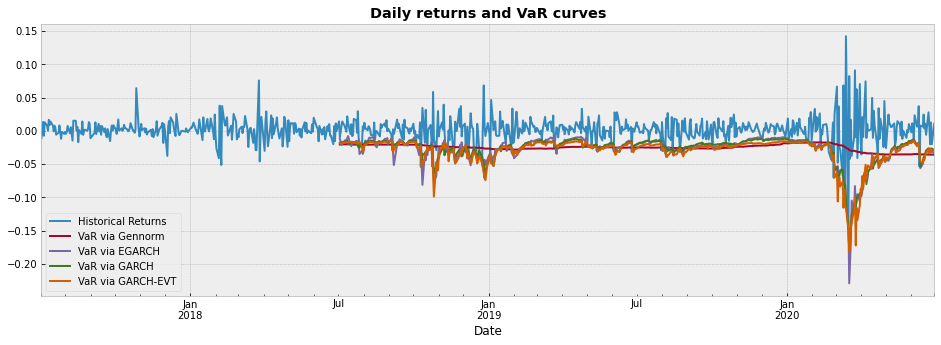

In [133]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_gennorm.plot()
VaR_egarch.plot()
VaR_garch.plot()
VaR_FHS.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Gennorm', 'VaR via EGARCH',
           'VaR via GARCH', 'VaR via GARCH-EVT'])

plt.show()

In [142]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

def backtest_VaR(r, VaR, level, L=None):
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')
    
def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

In [143]:
backtest_VaR(ret, VaR_gennorm, 1-alpha)
backtest_VaR(ret, VaR_garch, 1-alpha)
backtest_VaR(ret, VaR_egarch, 1-alpha)
backtest_VaR(ret, VaR_FHS, 1-alpha)

Backtesting calculate_VaR_gennorm:
Two-sided p-val 0.0073, one-sided: 0.00476
yellow zone

Backtesting calculate_VaR_garch:
Two-sided p-val 0.411, one-sided: 0.235
green zone

Backtesting calculate_VaR_egarch:
Two-sided p-val 0.08, one-sided: 0.0465
green zone

Backtesting calculate_VaR_FHS:
Two-sided p-val 1.0, one-sided: 0.533
green zone



GARCH-EVT is more suitable